# Imports

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.metrics as metrics
import sklearn.cluster as cluster

In [2]:
f = open('SMAI-Dataset-customer-dataset/data.csv', 'r')
headers = f.readline().strip().split(',')

l = []
while True:
    line = f.readline()
    if line == '':
        break
    l.append([int(i) for i in line.strip().split(',')])
    
l = np.array(l)[:, 1:]

# GMM Implementation

In [3]:
class GMM:
    def __init__(self, max_iters):
        self.mu = None
        self.cov = None
        self.phi = None
        self.weights = None
        self.max_iters = max_iters
    
            
    def expectation(self, data, n):
        weights = np.zeros((n, data.shape[0]))
        for i in range(n):
            weights[i] = stats.multivariate_normal.pdf(data, self.mu[i], self.cov[i], allow_singular=True) * self.phi[i]
            
        return np.array(weights)/np.sum(weights, axis=0)
        
    def maximization(self, data, n):
        mu = np.zeros((n, data.shape[1]))
        cov = np.ones((n, data.shape[1], data.shape[1]))
        phi = np.zeros(n)
        
        for i in range(n):
            # phi
            phi[i] = np.mean(self.weights[i])
            
            # mean
            
            # data2 = np.zeros(data.shape)
            # for j in range(data.shape[0]):
            #     data2[j] = data[j] * self.weights[i][j]
            data2 = data * self.weights[i].reshape(-1, 1)

            mu[i] = np.sum(data2, axis=0) / np.sum(self.weights[i])
            
            # covariance
            
            # elem = np.zeros((data.shape[0], data.shape[1], data.shape[1]))
            # for j in range(data.shape[0]):
            #     elem[j] = self.weights[i][j] * (data[j] - mu[i]).reshape(-1, 1) @ (data[j] - mu[i]).reshape(1, -1)
            elem = self.weights[i].reshape(-1, 1, 1) * ((data - mu[i])[:, :, np.newaxis] @ (data - mu[i])[:, np.newaxis, :])
            cov[i] = np.sum(elem, axis=0) / np.sum(self.weights[i])
            
        # print(self.phi)
            
        return mu, cov, phi
    
    def fit(self, data, n):
        self.mu = np.zeros((n, data.shape[1]))
        indices = np.random.choice(data.shape[0], n, replace=False)
        for i in range(n):
            self.mu[i] = data[indices[i]]
        self.phi = np.ones(n) / n
        self.cov = np.ones((n, data.shape[1], data.shape[1]))
        for i in range(n):
            self.cov[i] = np.cov(data, rowvar=False)
            
        num_iter = 0
        
        while True:
            # expectation
            self.weights = self.expectation(data, n)
            # maximization
            mu, self.cov, self.phi = self.maximization(data, n)
            
            if np.abs((self.mu - mu).sum()) < 10 or num_iter > 100:
                break
    
            self.mu = mu
            num_iter+=1
            
        return self.mu, self.cov, self.phi
    
    def parameters(self):
        return self.mu, self.cov, self.phi
    
    def membership(self, data):
        arr = np.zeros((data.shape[0]))
        for i in range(data.shape[0]):
            arr[i] = np.argmax(self.weights[:, i])
            
        return arr
    
    def log_likelihood(self, data, n):
        weights = np.zeros((n, data.shape[0]))
        for i in range(n):
            weights[i] = stats.multivariate_normal.pdf(data, self.mu[i], self.cov[i], allow_singular=True) * self.phi[i]
            
        return np.sum(np.log(np.sum(weights, axis=0)))
    

# Customer Dataset

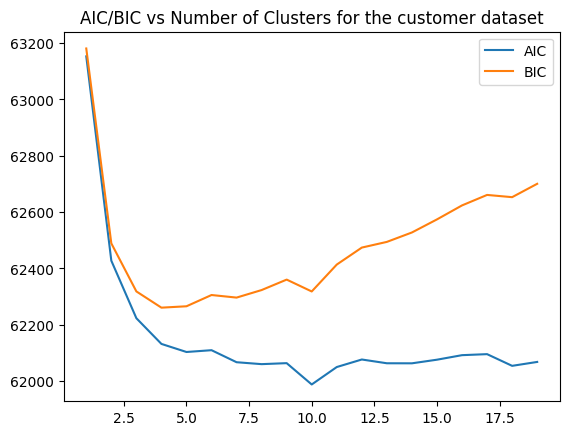

In [8]:
data = decomposition.PCA(n_components=2).fit_transform(l)
# data = l

AICs = []
BICs = []

for i in range(1, 20):
    # print("iteration", i)
    gmm = GMM(100)
    gmm.fit(data, i)
    # num of params = num of unique params in means + covs + weights
    p = (i * data.shape[1]) + (i * data.shape[1] * (data.shape[1] + 1) / 2) + (i - 1)  
    aic = 2 * p - 2 * gmm.log_likelihood(data, i)
    bic = p * np.log(data.shape[0]) - 2 * gmm.log_likelihood(data, i)
    
    AICs.append(aic)
    BICs.append(bic)
    # print(i, aic, bic)
    
x = np.arange(1, 20)
plt.plot(x, AICs, label='AIC')
plt.plot(x, BICs, label='BIC')
plt.title('AIC/BIC vs Number of Clusters for the customer dataset')
plt.legend()
plt.show()

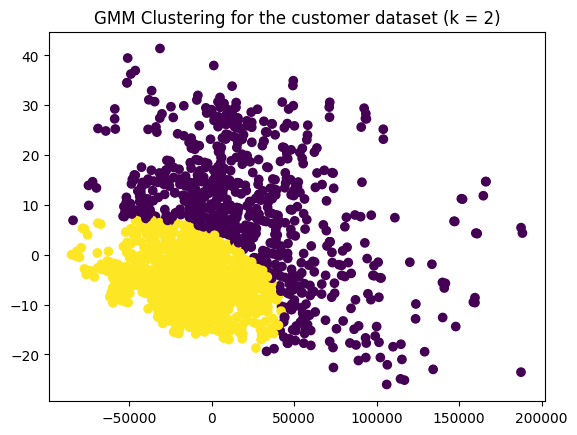

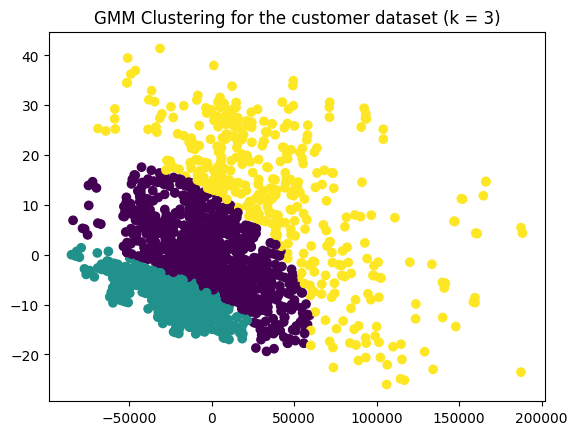

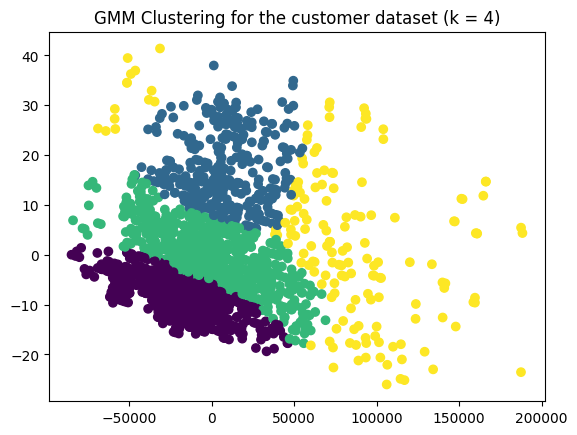

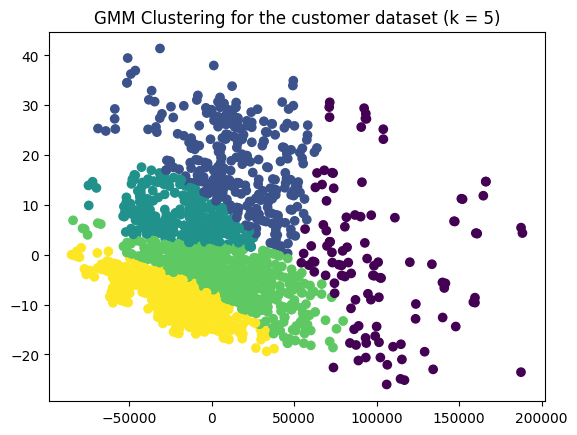

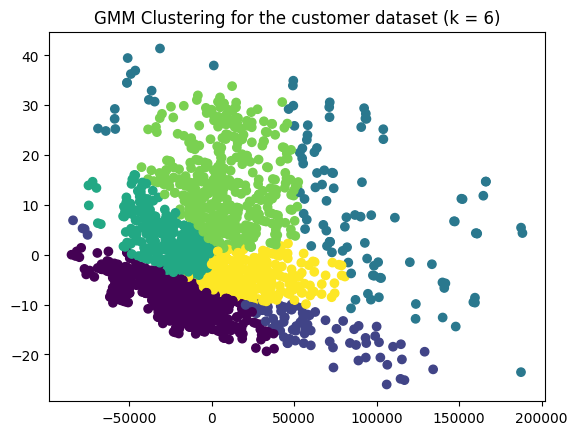

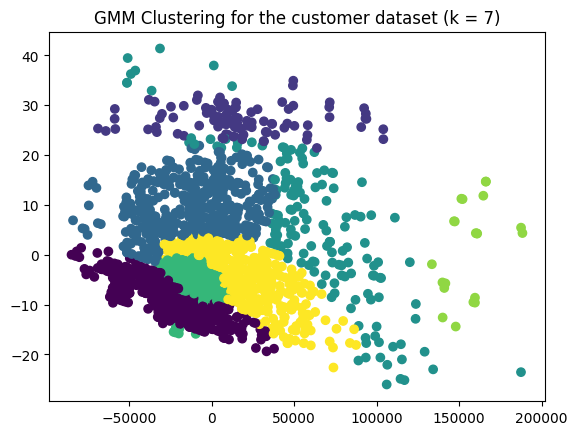

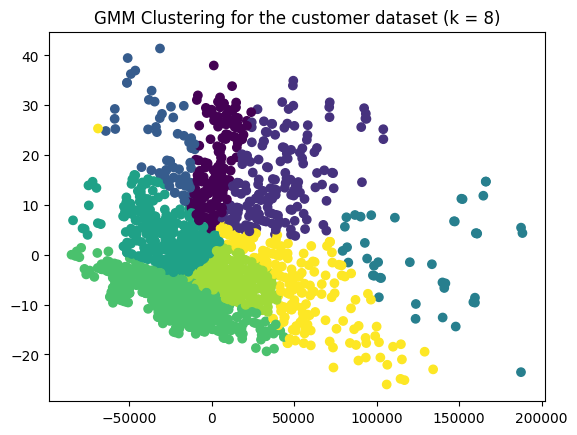

In [7]:
pca_l = decomposition.PCA(n_components=2).fit_transform(l)
# pca_l2 = decomposition.PCA(n_components=2).fit_transform(l)
for i in range(2, 9):
    gmm = GMM(350)
    mu,cov,phi = gmm.fit(pca_l, i)
    m = gmm.membership(pca_l)

    # gmm = mixture.GaussianMixture(n_components=6, covariance_type='full', init_params='k-means++')
    # m = gmm.fit_predict(l)

    plt.scatter(pca_l[:, 0], pca_l[:, 1], c=m)
    plt.title('GMM Clustering for the customer dataset (k = {})'.format(i))
    plt.show()

## Observations
* We observe from the AIC/BIC graphs that `k = (3-5)` gives us the least penalty and therefore better clustering.
* From the scatter plots, we can observe that for `k = 2`, the clustering of points observed is not very distinguishing and therefore we need more clusters for unsupervised learning.
* Also, for values of `k = 6, 7, 8`, smaller clusters are formed within each cluster in `k=3` and the clustering is unoptimal. (Since 2 clusters can be combined for better unsupervised learning).
* Therefore, for `k = 3, 4` we observe optimality for the GMM clustering of this dataset.

# Wine Dataset

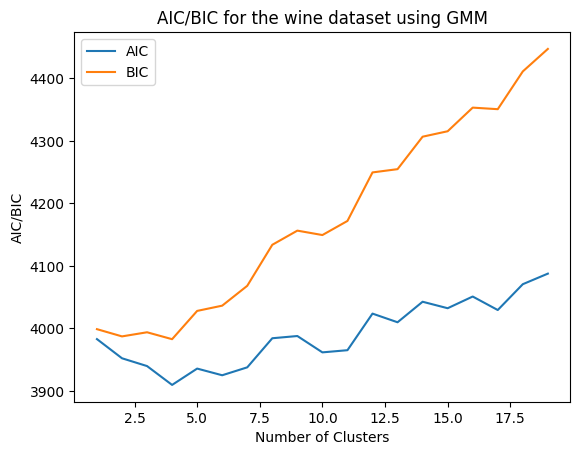

In [12]:
wine = datasets.load_wine()
data = wine.data
data = decomposition.PCA(n_components=2).fit_transform(data)

AICs = []
BICs = []

for i in range(1, 20):
    gmm = GMM(100)
    gmm.fit(data, i)
    # num of params = num of unique params in means + covs + weights
    p = (i * data.shape[1]) + (i * data.shape[1] * (data.shape[1] + 1) / 2) + (i - 1)  
    aic = 2 * p - 2 * gmm.log_likelihood(data, i)
    bic = p * np.log(data.shape[0]) - 2 * gmm.log_likelihood(data, i)
    
    AICs.append(aic)
    BICs.append(bic)
    
x = np.arange(1, 20)
plt.plot(x, AICs, label='AIC')
plt.plot(x, BICs, label='BIC')
plt.title('AIC/BIC for the wine dataset using GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC/BIC')
plt.legend()
plt.show()

## Observations
* Akaike Information Criterion (AIC) = `-2 * LL + 2 * k`
* Bayesian Information Criterion (BIC) = `-2 * LL + ln(N) * k`

where LL = log likelihood, k = no. of parameters & N = no. of datapoints

* Therefore, we can say that the AIC statistic penalizes complex models lesser than BIC.
* Also, BIC penalizes the model more for its complexity, so complex models will have a larger score.

* We select the the no. of components for each dataset where the AIC/BIC statistic are the lowest.
* Therefore, `optimal no. of clusters for the wine dataset = 3-5`

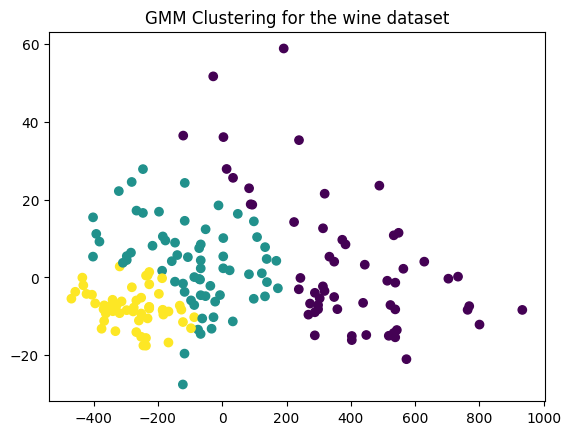

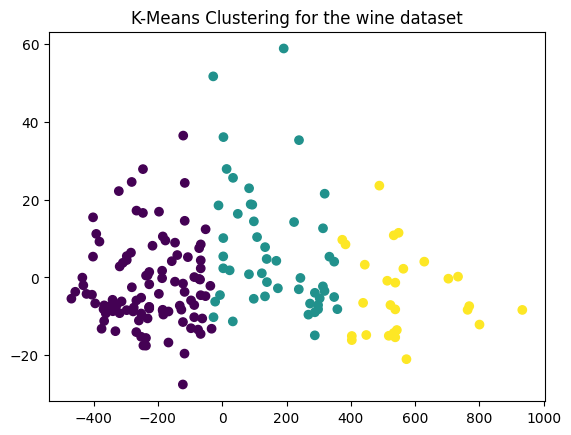

In [21]:
wine = datasets.load_wine()
pca_l = decomposition.PCA(n_components=2).fit_transform(wine.data)

gmm = GMM(350)
mu,cov,phi = gmm.fit(pca_l, 3)
m = gmm.membership(pca_l)
plt.scatter(pca_l[:, 0], pca_l[:, 1], c=m)
plt.title('GMM Clustering for the wine dataset')
plt.show()

m = cluster.KMeans(n_clusters=3, n_init=1).fit_predict(pca_l)
plt.scatter(pca_l[:, 0], pca_l[:, 1], c=m)
plt.title('K-Means Clustering for the wine dataset')
plt.show()

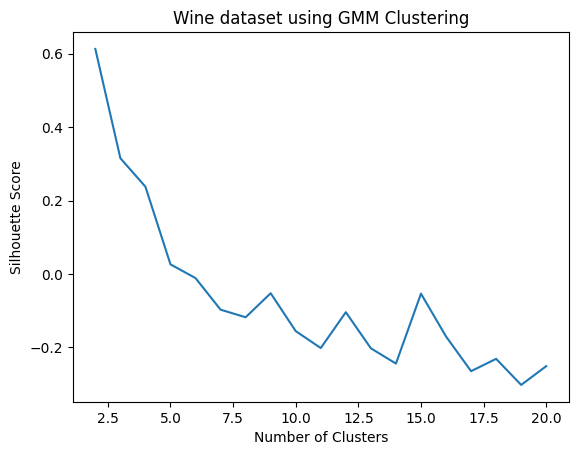

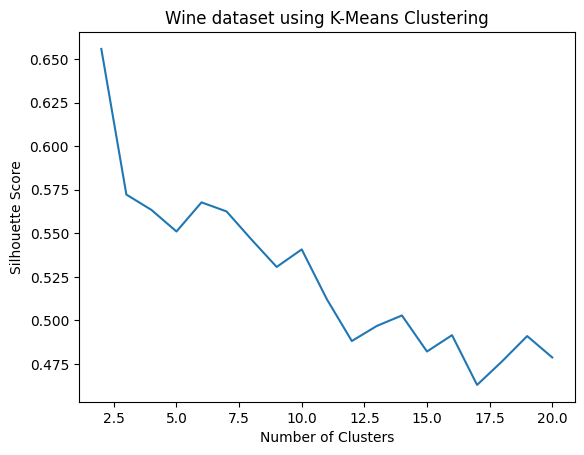

In [17]:
pca_l = decomposition.PCA(n_components=2).fit_transform(wine.data)

sil = []
for i in range(1, 20):
    gmm = GMM(350)
    mu,cov,phi = gmm.fit(pca_l, i+1)
    m = gmm.membership(pca_l)
    sil.append(metrics.silhouette_score(pca_l, m))
    
plt.plot(np.arange(2, 21), sil)
plt.title('Wine dataset using GMM Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

sil = []
for i in range(1, 20):
    m = cluster.KMeans(n_clusters=i+1, n_init=1).fit_predict(pca_l)
    sil.append(metrics.silhouette_score(pca_l, m))
    
plt.plot(np.arange(2, 21), sil)
plt.title('Wine dataset using K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Observations

* We observe that the clustering for GMM & K-means for `k = 3` is similar for the wine dataset, although GMM tends to incorporate more than just the x/y axis positions of the datapoints after pca.
* Also, the GMM clustering heavily depends on the initialisation of means which is randomized among the datapoints for each gaussian cluster.

* Silhouette scores tell us the seperation between clusters (including both intra and inter cluster) mathematically, which as we can see above, vary over the number of clusters in both GMM and K-Means clustering.
* If intra-cluster distance > inter-cluster distance, silhouette scores are negative. Therefore, that model is not suitable for clustering. (As we can see in a few GMM cases)